In [ ]:
# Dự báo churn theo thời gian cho Group A sử dụng toàn bộ dữ liệu (user_id)

## 1. Thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense

from darts import TimeSeries
from darts.models import NBEATSModel, TCNModel, NHiTSModel
from darts.metrics import smape

## 2. Đọc dữ liệu nhóm A
chunksize = 500000  # tùy chỉnh cho phù hợp RAM

chunks = []
for chunk in pd.read_csv(r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\ChiaNhom\Group(New)\2019_GroupA.csv", chunksize=chunksize):
    # Ép kiểu thời gian, lọc dòng lỗi
    chunk['event_time'] = pd.to_datetime(chunk['event_time'], errors='coerce')
    chunk = chunk.dropna(subset=['event_time'])
    
    # Lọc cột cần thiết
    chunk = chunk[['event_time', 'user_id', 'churn']]
    
    # Tạo cột ngày (date)
    chunk['event_date'] = chunk['event_time'].dt.date
    
    # Tính churn rate theo ngày, user_id trong chunk
    daily_chunk = chunk.groupby(['event_date', 'user_id'])['churn'].max().reset_index()
    chunks.append(daily_chunk)

In [25]:
## 3. Tiền xử lý
# Ghép các chunk lại
df_daily = pd.concat(chunks)

# Tính trung bình churn rate mỗi ngày (có thể có nhiều user_id trong ngày)
daily_churn = df_daily.groupby('event_date')['churn'].mean().reset_index()
daily_churn.columns = ['date', 'churn_rate']

# Ép kiểu datetime cho cột date
daily_churn['date'] = pd.to_datetime(daily_churn['date'])

# Sắp xếp ngày tháng
daily_churn = daily_churn.sort_values('date').reset_index(drop=True)

# 4. Chuẩn bị dữ liệu time series
series = TimeSeries.from_dataframe(daily_churn, 'date', 'churn_rate')

In [26]:
## 5. Mô hình 1: XGBoost (tree-based)
# Tạo đặc trưng theo ngày
daily_churn['dayofweek'] = daily_churn['date'].dt.dayofweek
daily_churn['day'] = daily_churn['date'].dt.day
daily_churn['month'] = daily_churn['date'].dt.month

X = daily_churn[['dayofweek', 'day', 'month']]
y = daily_churn['churn_rate']

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X, y)
y_pred_xgb = model_xgb.predict(X)

In [27]:
## 6. Mô hình 2: LSTM (Deep learning)
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(y.values.reshape(-1,1))

# Tạo dữ liệu theo chuỗi
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X_lstm, y_lstm = create_sequences(scaled_y, seq_length)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=20, verbose=1)

# Dự báo toàn bộ
y_pred_lstm = model_lstm.predict(X_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3896
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3696
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3650
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3553
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3333
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2990
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2928
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2844
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2358
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2348
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2148
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2012
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1839
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1776
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1508
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━

In [28]:
## 7. Mô hình 3: TCN (Temporal Convolutional Network)
model_tcn = TCNModel(input_chunk_length=14, output_chunk_length=1, n_epochs=100, random_state=42)
model_tcn.fit(series)
pred_tcn = model_tcn.predict(len(series))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 152    | train
-------------------------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
## 8. Mô hình 4: NHiTS (Hiện đại hơn N-BEATS)
model_nhits = NHiTSModel(input_chunk_length=14, output_chunk_length=1, n_epochs=100, random_state=42)
model_nhits.fit(series)
pred_nhits = model_nhits.predict(len(series))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 824 K  | train
-------------------------------------------------------------
817 K     Trainable params
7.2 K     Non-trainable params
824 K     Total params
3.297     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

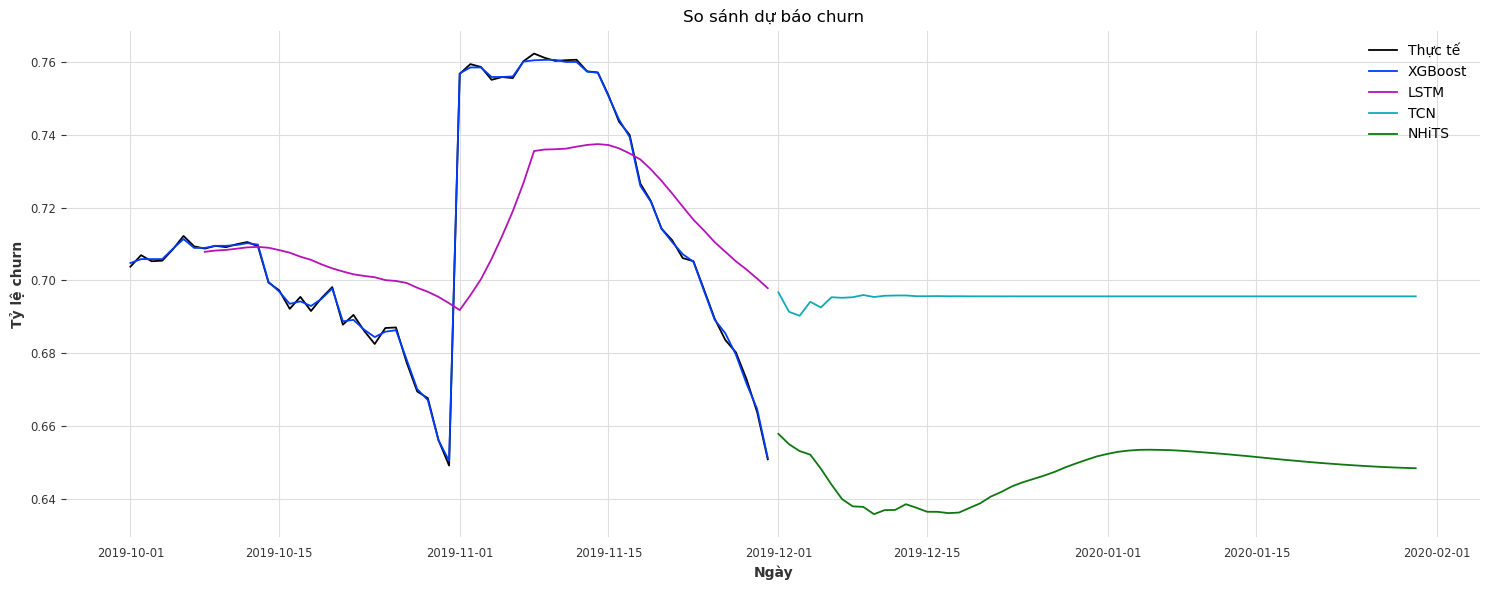

In [30]:
## 10. Trực quan hóa kết quả
plt.figure(figsize=(15,6))
plt.plot(daily_churn['date'], daily_churn['churn_rate'], label="Thực tế")
plt.plot(daily_churn['date'], y_pred_xgb, label="XGBoost")
plt.plot(daily_churn['date'].values[seq_length:], y_pred_lstm_inv.flatten(), label="LSTM")
plt.plot(pred_tcn.time_index, pred_tcn.values(), label="TCN")
plt.plot(pred_nhits.time_index, pred_nhits.values(), label="NHiTS")
plt.legend()
plt.title("So sánh dự báo churn")
plt.xlabel("Ngày")
plt.ylabel("Tỷ lệ churn")
plt.grid(True)
plt.tight_layout()
plt.show()